# Model

## Enviroment setup

In [1]:
# Connect with Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Paths

BASE_PATH = "/content/drive/MyDrive/TEC/AI/ProyectoBenji"

PATHS = {
  "CLEAN_DATA_PATH": f"{BASE_PATH}/data/clean",
  "PROCESSED_DATA_PATH": f"{BASE_PATH}/data/processed",
  "MODELS_PATH": f"{BASE_PATH}/models"
}

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# SciKit Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# TensorFlow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from collections import Counter
import pickle
import warnings
import os

warnings.filterwarnings('ignore')

In [4]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Detected: {len(gpus)} device(s)")
    for gpu in gpus:
        print(f"  - {gpu.name} ({gpu.device_type})")

    print("\nTensorFlow is configured to use the GPU.")
else:
    print("No GPU Detected. Please enable it in Runtime > Change runtime type > Hardware accelerator.")

GPU Detected: 1 device(s)
  - /physical_device:GPU:0 (GPU)

TensorFlow is configured to use the GPU.


## Data collection

In [5]:
# Parquet path
parquet_path = f"{PATHS['CLEAN_DATA_PATH']}/yelp_reviews_cleaned.parquet"

yelp_df = pd.read_parquet(parquet_path)

# Show info to understand structure
print("\nInfo of Yelp Reviews:")
yelp_df.info()

# Sample
yelp_df_display = yelp_df.copy()
yelp_df_display['tokens_filtered'] = yelp_df_display['tokens_filtered'].apply(lambda x: ' '.join(x))

print("\nSample:")
print(yelp_df_display.head().to_markdown(index=False))


Info of Yelp Reviews:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199131 entries, 0 to 199130
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             199131 non-null  object
 1   sentiment        199131 non-null  object
 2   text_length      199131 non-null  int64 
 3   word_count       199131 non-null  int64 
 4   text_clean       199131 non-null  object
 5   tokens           199131 non-null  object
 6   tokens_filtered  199131 non-null  object
dtypes: int64(2), object(5)
memory usage: 10.6+ MB

Sample:
| text                                                                                                                                                                                                                                                                                                                                                                                                   

## Data preparation



I'll divide the dataset into three distinct subsets to ensure proper model evaluation:
* Training Set (70%): Used to train the model weights.
* Validation Set (15%): Used to tune hyperparameters and monitor for overfitting.
* Test Set (15%): Used only once at the end to evaluate the final model.

In [6]:
# Split data into train, validation and test

# Split: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(yelp_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df):,}")
print(f"Validation: {len(val_df):,}")
print(f"Test: {len(test_df):,}")

Train: 139,391
Validation: 29,870
Test: 29,870


I'll separate the raw data into features and targets:
* Features (X): The 'tokens_filtered' column (cleaned text tokens).
* Labels (y): The 'sentiment' column (class labels).

In [7]:
# Extract text and labels

print("\nExtracting tokens and labels...")

train_tokens = train_df['tokens_filtered'].fillna('').tolist()
val_tokens = val_df['tokens_filtered'].fillna('').tolist()
test_tokens = test_df['tokens_filtered'].fillna('').tolist()

train_labels = train_df['sentiment'].tolist()
val_labels = val_df['sentiment'].tolist()
test_labels = test_df['sentiment'].tolist()

print(f"\nExample tokens: {train_tokens[0][:10]}")


Extracting tokens and labels...

Example tokens: ['shouldve' 'known' 'going' 'wild' 'ride' 'arent' 'capable' 'serving'
 'full' 'quiznos']


Machine learning models require numerical input. I'll use LabelEncoder to convert the string sentiment labels into integers:
* negative -> 0
* neutral  -> 1
* positive -> 2

In [8]:
# Encode labels

print("\nEncoding labels...")

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

print(f"Classes: {label_encoder.classes_}")
print(f"Label distribution (train): {np.bincount(train_labels_encoded)}")


Encoding labels...
Classes: ['negative' 'neutral' 'positive']
Label distribution (train): [46628 46469 46294]


I'll create a vocabulary of the top 20,000 most frequent words in the training set.
* <PAD> (Index 0): Reserved for padding sequences.
* <OOV> (Index 1): Reserved for "Out Of Vocabulary" words.

In [9]:
# Build vocabulary from training tokens

print("\nBuilding vocabulary from tokens...")

MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 200

# Count all words in training set
all_words = []
for tokens in train_tokens:
  all_words.extend(tokens)

word_counts = Counter(all_words)
print(f"\nTotal unique words in training: {len(word_counts):,}")

# Keep only top MAX_VOCAB_SIZE words
most_common = word_counts.most_common(MAX_VOCAB_SIZE - 2)  # -2 for <PAD> and <OOV>

# Create word-to-index mapping
word_to_index = {'<PAD>': 0, '<OOV>': 1}  # Reserve 0 for padding, 1 for unknown
for idx, (word, count) in enumerate(most_common, start=2):
  word_to_index[word] = idx

print(f"\nVocabulary size (including <PAD> and <OOV>): {len(word_to_index):,}")
print(f"\nUsing top {MAX_VOCAB_SIZE:,} words")


Building vocabulary from tokens...

Total unique words in training: 133,668

Vocabulary size (including <PAD> and <OOV>): 20,000

Using top 20,000 words


I'll replace every word in the reviews with its corresponding integer index.
* Words in dictionary -> mapped to index.
* Words not in dictionary -> mapped to <OOV> (Index 1).

In [10]:
# Converting tokens to numerical sequences

print("\nConverting tokens to numerical sequences...")

def tokens_to_sequences(tokens_list, word_to_index):
  sequences = []
  for tokens in tokens_list:
    sequence = [word_to_index.get(token, 1) for token in tokens]  # 1 = <OOV>
    sequences.append(sequence)
  return sequences

train_sequences = tokens_to_sequences(train_tokens, word_to_index)
val_sequences = tokens_to_sequences(val_tokens, word_to_index)
test_sequences = tokens_to_sequences(test_tokens, word_to_index)

print(f"\nExample transformation:")
print(f"    Tokens: {train_tokens[0][:10]}")
print(f"    Sequence: {train_sequences[0][:10]}")


Converting tokens to numerical sequences...

Example transformation:
    Tokens: ['shouldve' 'known' 'going' 'wild' 'ride' 'arent' 'capable' 'serving'
 'full' 'quiznos']
    Sequence: [2473, 1094, 53, 2334, 1471, 666, 6493, 741, 202, 11272]


I'll standardize the length of all sequences to 200 tokens for the LSTM.
* Shorter sequences -> padded with zeros (Index 0) at the end.
* Longer sequences -> truncated to keep only the first 200 tokens.

In [11]:
# Pad sequences

print("\nPadding sequences to same length...")

train_padded = pad_sequences(
  train_sequences,
  maxlen=MAX_SEQUENCE_LENGTH,
  padding='post',
  truncating='post',
  value=0
)

val_padded = pad_sequences(
  val_sequences,
  maxlen=MAX_SEQUENCE_LENGTH,
  padding='post',
  truncating='post',
  value=0
)

test_padded = pad_sequences(
    test_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post',
    value=0
)

print(f"Train shape: {train_padded.shape}")
print(f"Val shape: {val_padded.shape}")
print(f"Test shape: {test_padded.shape}")


Padding sequences to same length...
Train shape: (139391, 200)
Val shape: (29870, 200)
Test shape: (29870, 200)


Convert integer labels to categorical format (one-hot encoding) for the loss function. Then, save all processed arrays (.npy) and encoder objects (.pkl) to disk for later use.

In [12]:
# Convert to categorical

import os

train_labels_cat = to_categorical(train_labels_encoded, num_classes=3)
val_labels_cat = to_categorical(val_labels_encoded, num_classes=3)
test_labels_cat = to_categorical(test_labels_encoded, num_classes=3)

print(f"\nData preparation complete!")
print(f"Label shape: {train_labels_cat.shape}")

# Save for later use
print("\nSaving preprocessed data...")

# Create the directory if it doesn't exist
os.makedirs(PATHS["PROCESSED_DATA_PATH"], exist_ok=True)

np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/train_padded.npy', train_padded)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/val_padded.npy', val_padded)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/test_padded.npy', test_padded)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/train_labels_cat.npy', train_labels_cat)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/val_labels_cat.npy', val_labels_cat)
np.save(f'{PATHS["PROCESSED_DATA_PATH"]}/test_labels_cat.npy', test_labels_cat)

with open(f'{PATHS["PROCESSED_DATA_PATH"]}/word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)
with open(f'{PATHS["PROCESSED_DATA_PATH"]}/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Store for model building
VOCAB_SIZE = len(word_to_index)

print(f"Saved to {PATHS['PROCESSED_DATA_PATH']}")
print(f"\nFinal vocabulary size: {VOCAB_SIZE:,}")


Data preparation complete!
Label shape: (139391, 3)

Saving preprocessed data...
Saved to /content/drive/MyDrive/TEC/AI/ProyectoBenji/data/processed

Final vocabulary size: 20,000


## Baseline model

### Model architecture

This specific architecture is designed for sequence classification:

1. Embedding Layer (128 dim): Transforms sparse integer indices (words) into dense vectors. It learns the semantic meaning of words during training.

2. Bidirectional LSTM (64 units): Processes the text sequence in both directions (start-to-end and end-to-start). This allows the model to capture context from both past and future tokens, which is crucial for understanding sentiment.

3. Dropout (0.5): A regularization layer that randomly drops 50% of the connections during training. This prevents the model from memorizing the training data (overfitting).

4. Dense Output (3 units): The final layer with 'softmax' activation. It outputs a probability distribution across the 3 classes (Negative, Neutral, Positive).

In [13]:

# Model architecture

# Model parameters
VOCAB_SIZE = MAX_VOCAB_SIZE
EMBEDDING_DIM = 128  # Each word  128-dimensional vector
LSTM_UNITS = 64  # LSTM hidden state size
DROPOUT_RATE = 0.5

# Model
model = Sequential([
    # 1. Embedding Layer (learns word representations)
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH,
        name='embedding'
    ),

    # 2. Bidirectional LSTM (reads forward AND backward)
    Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=False),
        name='bidirectional_lstm'
    ),

    # 3. Dropout (regularization)
    Dropout(DROPOUT_RATE, name='dropout'),

    # 4. Dense Output Layer (3 classes: neg, neu, pos)
    Dense(3, activation='softmax', name='output')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Show architecture
print("\n Model Summary:")
model.summary()


 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Training parameters

BATCH_SIZE = 32
EPOCHS = 20

# Callbacks
callbacks = [
    # Early stopping: stop if val_loss doesn't improve for 3 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        f'{PATHS["MODELS_PATH"]}/baseline_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Reduce learning rate if stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=0.00001
    )
]

print(f"\n Training parameters:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   Callbacks: Early Stopping, Model Checkpoint, LR Reduction")


 Training parameters:
   Batch size: 32
   Max epochs: 20
   Callbacks: Early Stopping, Model Checkpoint, LR Reduction


### Training

In [15]:
# Train

baseline_model_path = f'{PATHS["MODELS_PATH"]}/baseline_model.keras'
baseline_model_training_history_path = f'{PATHS["MODELS_PATH"]}/baseline_model_training_history.pkl'

# Check if model exists to avoid retraining
if os.path.exists(baseline_model_path) and os.path.exists(baseline_model_training_history_path):
    print(f"\nModel found at {baseline_model_path}. Loading...")
    model = tf.keras.models.load_model(baseline_model_path)
    print("Model loaded successfully. Skipping training.")
else:
    print("\nStarting training...\n")

    # Train model
    history = model.fit(
        train_padded,
        train_labels_cat,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(val_padded, val_labels_cat),
        callbacks=callbacks,
        verbose=1
    )

    print("\nTraining complete!")

    # Save final model
    model.save(baseline_model_path)
    print(f"Model saved to {baseline_model_path}")

    # Save history
    with open(baseline_model_training_history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"Training history saved to {baseline_model_training_history_path}")


Model found at /content/drive/MyDrive/TEC/AI/ProyectoBenji/models/baseline_model.keras. Loading...
Model loaded successfully. Skipping training.


### Results


Loading training history...
Training statistics:

Best epoch: 2/5
Best validation accuracy: 0.7830 (78.30%)
Best validation loss: 0.5244

Final epoch:
    Train accuracy: 0.8964 (89.64%)
    Val accuracy: 0.7616 (76.16%)

Potential overfitting detected (gap: 0.1348)

Generating Confusion Matrix on Test Set...
934/934 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


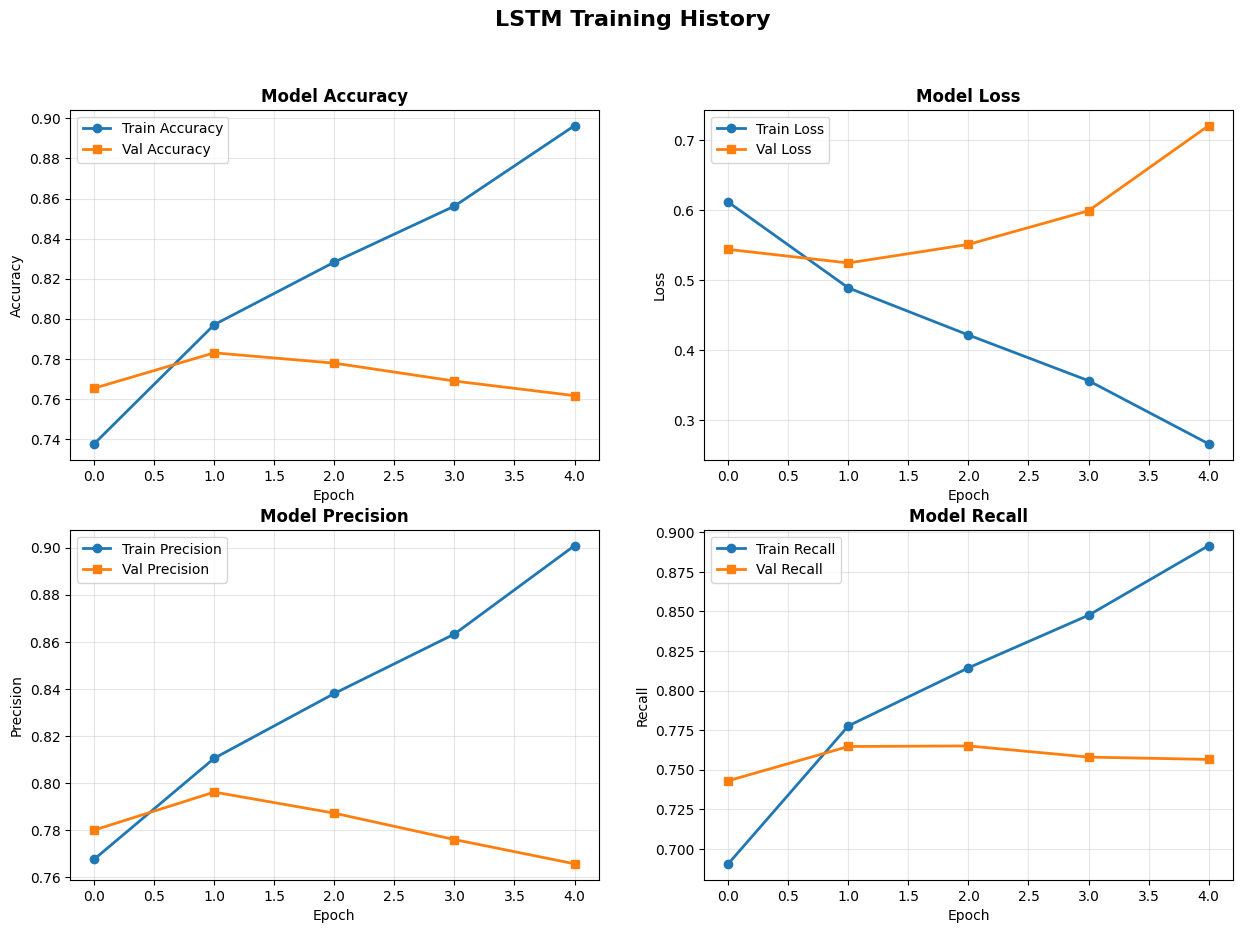

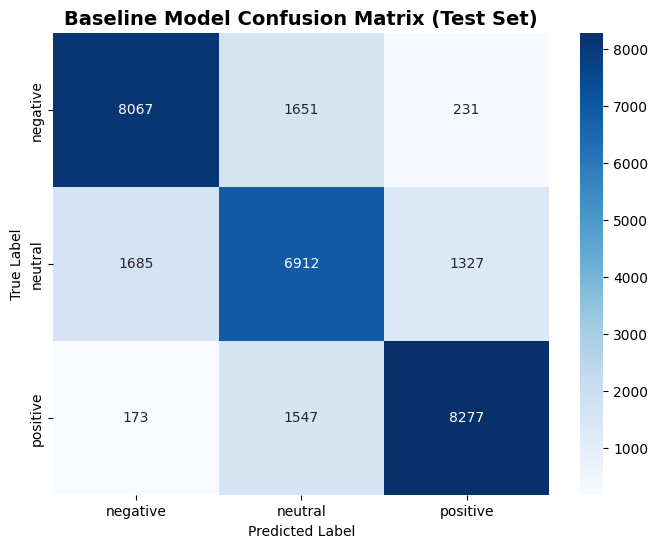

In [16]:
# Results

# Load training history
print("\nLoading training history...")

with open(baseline_model_training_history_path, 'rb') as f:
    history_dict = pickle.load(f)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LSTM Training History', fontsize=16, fontweight='bold')

# 1. Accuracy
axes[0, 0].plot(history_dict['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0, 0].plot(history_dict['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss
axes[0, 1].plot(history_dict['loss'], label='Train Loss', linewidth=2, marker='o')
axes[0, 1].plot(history_dict['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision
axes[1, 0].plot(history_dict['precision'], label='Train Precision', linewidth=2, marker='o')
axes[1, 0].plot(history_dict['val_precision'], label='Val Precision', linewidth=2, marker='s')
axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Recall
axes[1, 1].plot(history_dict['recall'], label='Train Recall', linewidth=2, marker='o')
axes[1, 1].plot(history_dict['val_recall'], label='Val Recall', linewidth=2, marker='s')
axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Print statistics
print("Training statistics:")

best_epoch = np.argmax(history_dict['val_accuracy']) + 1
best_val_acc = np.max(history_dict['val_accuracy'])
best_val_loss = np.min(history_dict['val_loss'])
final_train_acc = history_dict['accuracy'][-1]
final_val_acc = history_dict['val_accuracy'][-1]

print(f"\nBest epoch: {best_epoch}/{len(history_dict['loss'])}")
print(f"Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"\nFinal epoch:")
print(f"    Train accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"    Val accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# Check for overfitting
overfit_gap = final_train_acc - final_val_acc
if overfit_gap > 0.1:
    print(f"\nPotential overfitting detected (gap: {overfit_gap:.4f})")
elif overfit_gap > 0.05:
    print(f"\nSlight overfitting (gap: {overfit_gap:.4f})")
else:
    print(f"\nGood generalization (gap: {overfit_gap:.4f})")

# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\nGenerating Confusion Matrix on Test Set...")
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels_cat, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Baseline Model Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()